In [1]:
from torch import nn
import torch

In [2]:
from torch.nn.utils.rnn import pad_sequence

In [3]:
import numpy as np

In [4]:
import pandas as pd

In [5]:
import os

In [6]:
from einops import rearrange

In [7]:
import random

In [8]:
from torch.utils.data import DataLoader

In [9]:
import torchvision.transforms as T

In [10]:
from skimage.util import random_noise

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [12]:
import torchaudio

C:\Users\aag12\anaconda3\envs\ml_env\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [13]:
from sklearn import preprocessing

In [14]:
from sklearn.model_selection import train_test_split

# Defining Dataset

In [15]:
from datasets import load_dataset

In [16]:
from datasets import disable_caching
disable_caching()

In [17]:
with open("goodfiles.txt", 'r') as f:
    all_files = f.readlines()
all_files = [g.strip().replace("npy", 'mp3') for g in all_files if len(g.strip()) > 0]

In [18]:
all_files[:3]

['01/846501.mp3', '34/1288334.mp3', '98/1082098.mp3']

In [19]:
len(all_files)

2751

In [20]:
good_files, test_files = train_test_split(all_files, test_size=0.2)

In [21]:
len(good_files), len(test_files)

(2200, 551)

In [22]:
def files_to_labels(files):
    col_names = ['TRACK_ID',
     'ARTIST_ID',
     'ALBUM_ID',
     'PATH',
     'DURATION',
     'TAGS',
     'TAGS2',
     'TAGS3',
     'TAGS4',
     'TAGS5',
     'TAGS6',
     'TAGS7',
     'TAGS8',
     'TAGS9']
    MOODPATH = "../../../Downloads/autotagging_moodtheme.tsv.txt"
    df = pd.read_csv(MOODPATH, sep='\t', names=col_names)
    df = df[df["PATH"].isin(files)]
    inds = {'fast': 0,
     'sexy': 1,
     'mellow': 2,
     'heavy': 3,
     'horror': 4,
     'travel': 5,
     'holiday': 6,
     'groovy': 7,
     'funny': 8,
     'retro': 9,
     'hopeful': 10,
     'powerful': 11,
     'cool': 12,
     'nature': 13,
     'game': 14}

    final_labels = []
    for i in range(len(df)):
        curr = np.zeros(len(inds))
        moods = list(df.iloc[i])[5:]
        for theme in moods:
            if type(theme) == str and "mood" in theme:
                check = theme.split("---")[-1]
                if check in inds:
                    curr[inds[check]] = 1
            else:
                pass

        final_labels.append(curr)
    return final_labels

In [23]:
train_labels = files_to_labels(good_files)

In [24]:
test_labels = files_to_labels(test_files)

In [25]:
train_labels[:2]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])]

In [26]:
# train_np_files = [("../../subset_moodtheme/" + g).replace(".mp3", ".npy") for g in good_files]
# test_np_files = [("../../subset_moodtheme/" + g).replace(".mp3", ".npy") for g in test_files]
train_np_files = ["../../mtg-jamendo-dataset/all_data/" + g.replace("mp3", "npy") for g in good_files]
test_np_files = ["../../mtg-jamendo-dataset/all_data/" + g.replace("mp3", "npy") for g in test_files]

In [27]:
train_np_files[:2], test_np_files[:2]

(['../../mtg-jamendo-dataset/all_data/34/1342134.npy',
  '../../mtg-jamendo-dataset/all_data/49/785649.npy'],
 ['../../mtg-jamendo-dataset/all_data/45/1310245.npy',
  '../../mtg-jamendo-dataset/all_data/62/88462.npy'])

In [28]:
import time

In [29]:
# SEQ_LEN = 10000
SEQ_LEN = 3000
# SEQ_LEN = 5000

# Dataset

In [30]:
from torchvision import transforms

In [31]:
class MusicDataset(torch.utils.data.Dataset):   
    def __init__(self, np_file_paths, labels, transforms, seq_len=10000, random_start=True, upsample_factor=10):
        self.seq_len = seq_len
        self.files = np_file_paths
        self.labels = labels
        self.transforms = transforms
        self.random_start = random_start
        self.upsample_factor = upsample_factor
        
    def __len__(self):
        return len(self.files) * self.upsample_factor

    def __getitem__(self, index):
        effective_index = index % len(self.files)
        fname = self.files[effective_index]
        x = np.load(fname)
        x = torch.from_numpy(x).float()
        if self.random_start and x.shape[-1] > self.seq_len:
            # longer than seqlen, select random subset
            start = random.randint(0, x.shape[-1] - self.seq_len)
            x = x[:,start:start+self.seq_len]
        else:
            x = x[:,:self.seq_len]
        old_x = x.unsqueeze(0)
        # clamp between bounds and scale
        compressed_x = (torch.clamp(old_x, min=-90, max=30) + 90) / 120
        
        x = self.transforms(compressed_x)
        
#         item = {"input": x, "label_ids":[effective_index], "labels": torch.tensor(self.labels[effective_index])}
        item = {"input": x, "pixel_values":x}
        
        return item

In [32]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [33]:
img_size = 496
noise_composed = transforms.Compose([
   transforms.Resize((96, img_size)),
#     transforms.Normalize((0.5542), (0.1604)),
    AddGaussianNoise(0., 0.04)
])
nonoise_composed = transforms.Compose([
   transforms.Resize((96, img_size)),
#     transforms.Normalize((0.5542), (0.1604))
])

In [34]:
pt_train_dataset = MusicDataset(train_np_files, train_labels, noise_composed, seq_len=SEQ_LEN, random_start=True, upsample_factor=5)
pt_test_dataset = MusicDataset(test_np_files, test_labels, nonoise_composed, seq_len=SEQ_LEN, random_start=False, upsample_factor=1)

In [35]:
batch_size = 32

In [36]:
train_dl = DataLoader(
    pt_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

test_dl = DataLoader(
    pt_test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

# SMALL

In [37]:
from vit_pytorch.vit_for_small_dataset import ViT

In [44]:
v = ViT(
    image_size = (96, 496),
    patch_size = 16,
    num_classes = 15,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1,
    channels=1
)

# img = torch.randn(4, 3, 256, 256)

# preds = v(img) # (1, 1000)

In [45]:
img = torch.randn(4, 1, 96, 496)

preds = v(img) # (1, 1000)

In [46]:
preds.shape

torch.Size([4, 15])

## MAE

In [38]:
from vit_pytorch import ViT, MAE

In [39]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [40]:
v = ViT(
    image_size = (96, 496),
#     patch_size = 32,
    patch_size = 16,
    num_classes = 15,
#     dim = 1024,
    dim = 512,
    depth = 4,
    heads = 6,
    mlp_dim = 1024,
#     mlp_dim = 512,
    channels=1
)
mae = MAE(
    encoder = v,
    masking_ratio = 0.75,   # the paper recommended 75% masked patches
    decoder_dim = 512,      # paper showed good results with just 512
    decoder_depth = 4       # anywhere from 1 to 8
)

In [41]:
from tqdm import tqdm
import torch.optim as optim

In [42]:
mae = mae.to(device)

In [43]:
def get_total_loss(model, dataloader):
    total_loss = 0
    for batch_idx, data in enumerate(dataloader):
        loss = mae(data['input'].to(device))
        total_loss += loss.item()
    return total_loss

In [45]:
# optimizer = optim.AdamW(mae.parameters(), lr=1e-2)
# optimizer = optim.AdamW(mae.parameters(), lr=5e-2, weight_decay=0.05, betas=(0.9, 0.95))
# optimizer = optim.AdamW(mae.parameters(), lr=5e-3, weight_decay=0.05, betas=(0.9, 0.95))
optimizer = optim.AdamW(mae.parameters(), lr=1e-4, weight_decay=0.05, betas=(0.9, 0.95))

In [46]:
train_losses = []
test_losses = []
for epoch in range(100):
    total_loss = 0
    for batch_idx, data in tqdm(enumerate(train_dl), total=len(train_dl)):
        optimizer.zero_grad()
        inputs = data['input'].to(device)
        loss = mae(inputs)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    with torch.no_grad():
        test_loss = get_total_loss(mae, test_dl)
        train_losses.append(total_loss)
        test_losses.append(test_loss)
        print(f"Epoch: {epoch}; Loss: {total_loss}; Test Loss: {test_loss}")
    if test_loss == min(test_losses):
        torch.save(v.state_dict(), f"./v2-nonorm-trained-vit-{epoch}.pt")

_ = mae.eval()

100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:55<00:00,  2.98it/s]


Epoch: 0; Loss: 15.344200090505183; Test Loss: 6.610148323932663


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:24<00:00,  4.08it/s]


Epoch: 1; Loss: 3.513505999930203; Test Loss: 6.59189169248566


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:22<00:00,  4.15it/s]


Epoch: 2; Loss: 3.1630238592624664; Test Loss: 5.406363937538117


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.11it/s]


Epoch: 3; Loss: 2.90708144987002; Test Loss: 4.602846526657231


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.10it/s]


Epoch: 4; Loss: 2.7371703814715147; Test Loss: 4.2607511999085546


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.11it/s]


Epoch: 5; Loss: 2.650710437912494; Test Loss: 4.186699604731984


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:22<00:00,  4.18it/s]


Epoch: 6; Loss: 2.6053989119827747; Test Loss: 4.01802606950514


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:21<00:00,  4.21it/s]


Epoch: 7; Loss: 2.5658372435718775; Test Loss: 4.019125393242575


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.13it/s]


Epoch: 8; Loss: 2.533442868385464; Test Loss: 3.89404148387257


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.11it/s]


Epoch: 9; Loss: 2.481796381995082; Test Loss: 3.964098206604831


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:22<00:00,  4.16it/s]


Epoch: 10; Loss: 2.4494832884520292; Test Loss: 3.7110875074286014


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:21<00:00,  4.20it/s]


Epoch: 11; Loss: 2.4228087570518255; Test Loss: 3.578687708126381


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.13it/s]


Epoch: 12; Loss: 2.3839676352217793; Test Loss: 3.5862706422340125


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:22<00:00,  4.15it/s]


Epoch: 13; Loss: 2.352856366895139; Test Loss: 3.4230524046579376


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.11it/s]


Epoch: 14; Loss: 2.3113410444930196; Test Loss: 3.360196159919724


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.10it/s]


Epoch: 15; Loss: 2.2712915162555873; Test Loss: 3.178102829842828


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.10it/s]


Epoch: 16; Loss: 2.2182294642552733; Test Loss: 3.201298483530991


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.10it/s]


Epoch: 17; Loss: 2.185006903950125; Test Loss: 3.089176359702833


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:24<00:00,  4.09it/s]


Epoch: 18; Loss: 2.1526135532185435; Test Loss: 3.0665057182777673


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.11it/s]


Epoch: 19; Loss: 2.1290742945857346; Test Loss: 2.985006075585261


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.10it/s]


Epoch: 20; Loss: 2.1068376349285245; Test Loss: 2.9240052538225427


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.11it/s]


Epoch: 21; Loss: 2.0808519017882645; Test Loss: 2.868760003009811


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.12it/s]


Epoch: 22; Loss: 2.0709893964231014; Test Loss: 2.8424632841488346


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.11it/s]


Epoch: 23; Loss: 2.0567031893879175; Test Loss: 2.802648182725534


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.11it/s]


Epoch: 24; Loss: 2.059714472386986; Test Loss: 2.8460413116263226


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.13it/s]


Epoch: 25; Loss: 2.0468187644146383; Test Loss: 2.8755417083157226


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:22<00:00,  4.15it/s]


Epoch: 26; Loss: 2.041488565504551; Test Loss: 2.807764008990489


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:21<00:00,  4.20it/s]


Epoch: 27; Loss: 2.0353220994584262; Test Loss: 2.814927387633361


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:21<00:00,  4.20it/s]


Epoch: 28; Loss: 2.031096324790269; Test Loss: 2.7432271806756034


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:22<00:00,  4.17it/s]


Epoch: 29; Loss: 2.026759745553136; Test Loss: 2.755297629511915


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:22<00:00,  4.18it/s]


Epoch: 30; Loss: 2.0244580726139247; Test Loss: 2.7920770805794746


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:22<00:00,  4.19it/s]


Epoch: 31; Loss: 2.013091070111841; Test Loss: 2.766861172975041


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.14it/s]


Epoch: 32; Loss: 2.0185239729471505; Test Loss: 2.7800831547938287


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.14it/s]


Epoch: 33; Loss: 2.0077544637024403; Test Loss: 2.7151629202999175


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.12it/s]


Epoch: 34; Loss: 2.0071051963604987; Test Loss: 2.820856375969015


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.12it/s]


Epoch: 35; Loss: 1.9993085861206055; Test Loss: 2.6884624474914744


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.12it/s]


Epoch: 36; Loss: 1.992238654755056; Test Loss: 2.7377977576106787


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.12it/s]


Epoch: 37; Loss: 1.9960255841724575; Test Loss: 2.7117835759418085


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:22<00:00,  4.15it/s]


Epoch: 38; Loss: 1.9939713017083704; Test Loss: 2.639150468981825


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:24<00:00,  4.08it/s]


Epoch: 39; Loss: 1.9909831089898944; Test Loss: 2.743065953371115


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:21<00:00,  4.22it/s]


Epoch: 40; Loss: 1.9898360655643046; Test Loss: 2.7329757909756154


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:21<00:00,  4.21it/s]


Epoch: 41; Loss: 1.9824937069788575; Test Loss: 2.726958565355744


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:21<00:00,  4.22it/s]


Epoch: 42; Loss: 1.9842366981320083; Test Loss: 2.6973871021182276


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:21<00:00,  4.21it/s]


Epoch: 43; Loss: 1.9847998982295394; Test Loss: 2.752673002425581


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:21<00:00,  4.21it/s]


Epoch: 44; Loss: 1.9808527282439172; Test Loss: 2.734314592787996


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:21<00:00,  4.21it/s]


Epoch: 45; Loss: 1.9727884326130152; Test Loss: 2.5893318958114833


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:21<00:00,  4.22it/s]


Epoch: 46; Loss: 1.9688240364193916; Test Loss: 2.708021179540083


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:21<00:00,  4.22it/s]


Epoch: 47; Loss: 1.9647269807755947; Test Loss: 2.651888031454291


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:21<00:00,  4.21it/s]


Epoch: 48; Loss: 1.966069670394063; Test Loss: 2.7138389201718383


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:21<00:00,  4.21it/s]


Epoch: 49; Loss: 1.9623535899445415; Test Loss: 2.631964232889004


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:21<00:00,  4.23it/s]


Epoch: 50; Loss: 1.960495884064585; Test Loss: 2.613614299800247


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:21<00:00,  4.21it/s]


Epoch: 51; Loss: 1.9598961477167904; Test Loss: 2.6194853076012805


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:21<00:00,  4.22it/s]


Epoch: 52; Loss: 1.9568711095489562; Test Loss: 2.592335329100024


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:21<00:00,  4.21it/s]


Epoch: 53; Loss: 1.948110164143145; Test Loss: 2.644770245766267


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:21<00:00,  4.23it/s]


Epoch: 54; Loss: 1.9574350276961923; Test Loss: 2.6008646627306007


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:21<00:00,  4.21it/s]


Epoch: 55; Loss: 1.9467636486515403; Test Loss: 2.660505029838532


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:22<00:00,  4.19it/s]


Epoch: 56; Loss: 1.9449819582514465; Test Loss: 2.583317874581553


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:22<00:00,  4.17it/s]


Epoch: 57; Loss: 1.9539462248794734; Test Loss: 2.604471466038376


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:22<00:00,  4.18it/s]


Epoch: 58; Loss: 1.9404792697168887; Test Loss: 2.646424699923955


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:22<00:00,  4.17it/s]


Epoch: 59; Loss: 1.9377613090910017; Test Loss: 2.6552439618390054


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.14it/s]


Epoch: 60; Loss: 1.93643022980541; Test Loss: 2.618788514926564


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.13it/s]


Epoch: 61; Loss: 1.9349260674789548; Test Loss: 2.618242261814885


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.12it/s]


Epoch: 62; Loss: 1.92983144428581; Test Loss: 2.585007255198434


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.13it/s]


Epoch: 63; Loss: 1.9293195866048336; Test Loss: 2.646480606053956


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.12it/s]


Epoch: 64; Loss: 1.9244386800564826; Test Loss: 2.633786051068455


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.13it/s]


Epoch: 65; Loss: 1.9240644266828895; Test Loss: 2.6228819638490677


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.11it/s]


Epoch: 66; Loss: 1.9272384839132428; Test Loss: 2.66627401614096


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.11it/s]


Epoch: 67; Loss: 1.9250709563493729; Test Loss: 2.6193680413998663


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.12it/s]


Epoch: 68; Loss: 1.9252594993449748; Test Loss: 2.605934380029794


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.11it/s]


Epoch: 69; Loss: 1.918467475567013; Test Loss: 2.6277068625204265


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.11it/s]


Epoch: 70; Loss: 1.9190910225734115; Test Loss: 2.5308843567036092


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.13it/s]


Epoch: 71; Loss: 1.9124423153698444; Test Loss: 2.5320889597642235


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.12it/s]


Epoch: 72; Loss: 1.9139571068808436; Test Loss: 2.533513182599563


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.12it/s]


Epoch: 73; Loss: 1.9097199393436313; Test Loss: 2.5147022113669664


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.13it/s]


Epoch: 74; Loss: 1.9097946383990347; Test Loss: 2.5810508730937727


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.12it/s]


Epoch: 75; Loss: 1.9104802329093218; Test Loss: 2.5669604842551053


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.13it/s]


Epoch: 76; Loss: 1.904054089449346; Test Loss: 2.567307229619473


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.12it/s]


Epoch: 77; Loss: 1.9055210039950907; Test Loss: 2.5637372256605886


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.13it/s]


Epoch: 78; Loss: 1.902746600098908; Test Loss: 2.5656359797576442


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.14it/s]


Epoch: 79; Loss: 1.8995123547501862; Test Loss: 2.5407141836476512


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:24<00:00,  4.08it/s]


Epoch: 80; Loss: 1.8950806967914104; Test Loss: 2.557575062615797


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.11it/s]


Epoch: 81; Loss: 1.8940832605585456; Test Loss: 2.562625081569422


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:21<00:00,  4.22it/s]


Epoch: 82; Loss: 1.8955876803956926; Test Loss: 2.5185295309638605


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:21<00:00,  4.21it/s]


Epoch: 83; Loss: 1.893781477585435; Test Loss: 2.5501075430074707


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:21<00:00,  4.21it/s]


Epoch: 84; Loss: 1.8886764021590352; Test Loss: 2.521909297676757


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:22<00:00,  4.19it/s]


Epoch: 85; Loss: 1.885632608551532; Test Loss: 2.5053305157343857


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:22<00:00,  4.18it/s]


Epoch: 86; Loss: 1.8851974462158978; Test Loss: 2.4859783893916756


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:22<00:00,  4.17it/s]


Epoch: 87; Loss: 1.885340128093958; Test Loss: 2.5132116252789274


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:22<00:00,  4.16it/s]


Epoch: 88; Loss: 1.8855215939693153; Test Loss: 2.5157984865945764


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:21<00:00,  4.21it/s]


Epoch: 89; Loss: 1.8814417631365359; Test Loss: 2.497790084045846


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:22<00:00,  4.18it/s]


Epoch: 90; Loss: 1.88009186508134; Test Loss: 2.538699807599187


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:21<00:00,  4.23it/s]


Epoch: 91; Loss: 1.8757441123016179; Test Loss: 2.4957122307969257


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:21<00:00,  4.20it/s]


Epoch: 92; Loss: 1.8768048440106213; Test Loss: 2.5249457525787875


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:22<00:00,  4.15it/s]


Epoch: 93; Loss: 1.8742371224798262; Test Loss: 2.459918896551244


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:21<00:00,  4.20it/s]


Epoch: 94; Loss: 1.8733190456405282; Test Loss: 2.5326198656694032


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:22<00:00,  4.17it/s]


Epoch: 95; Loss: 1.8666010363958776; Test Loss: 2.433802089537494


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.12it/s]


Epoch: 96; Loss: 1.867110341321677; Test Loss: 2.5270709543838166


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.11it/s]


Epoch: 97; Loss: 1.8641439946368337; Test Loss: 2.4871367016457953


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.12it/s]


Epoch: 98; Loss: 1.859732844401151; Test Loss: 2.471405997115653


100%|████████████████████████████████████████████████████████████████████████████████████████| 344/344 [01:23<00:00,  4.12it/s]


Epoch: 99; Loss: 1.8653965182602406; Test Loss: 2.460257103026379


In [47]:
# torch.save(v.state_dict(), f"./lastnotbest-trained-vit-{epoch}.pt")
torch.save(mae.state_dict(), f"./v2-nonorm-maeklastnotbest-trained-vit-{epoch}.pt")

In [48]:
30 * 800 / 60 / 60

6.666666666666667

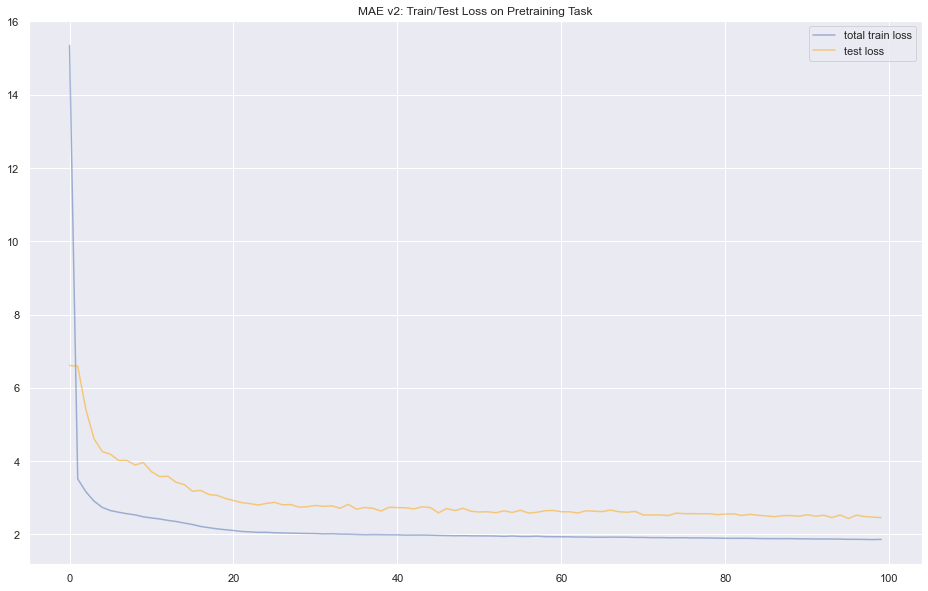

In [49]:
plt.figure(figsize=(16, 10))
ranger = list(range(len(train_losses)))
sns.lineplot(x=ranger, y=train_losses, label="total train loss", alpha=0.5)
# sns.lineplot(x=ranger, y=adjusted_train_losses, label="adjusted train loss")
# ax2 = plt.twinx()
# sns.lineplot(x=ranger, y=test_losses, label="test loss", ax=ax2, color="orange", alpha=0.5)
sns.lineplot(x=ranger, y=test_losses, label="test loss", color="orange", alpha=0.5)
plt.title("MAE v2: Train/Test Loss on Pretraining Task")
plt.savefig("mae_v2_nonorm.png")

In [51]:
mae.decoder

Transformer(
  (layers): ModuleList(
    (0): ModuleList(
      (0): PreNorm(
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (fn): Attention(
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.0, inplace=False)
          (to_qkv): Linear(in_features=512, out_features=1536, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Dropout(p=0.0, inplace=False)
          )
        )
      )
      (1): PreNorm(
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (fn): FeedForward(
          (net): Sequential(
            (0): Linear(in_features=512, out_features=2048, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=2048, out_features=512, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
      )
    )
    (1): ModuleList(
     

In [47]:
x = 1/0

ZeroDivisionError: division by zero

# Finetuning MAE for Task

In [ ]:
batch_size = 8

In [ ]:
class FinetuningMusicDataset(torch.utils.data.Dataset):   
    def __init__(self, np_file_paths, labels, transforms, seq_len=10000, random_start=True, upsample_factor=10):
        self.seq_len = seq_len
        self.files = np_file_paths
        self.labels = labels
        self.transforms = transforms
        self.random_start = random_start
        self.upsample_factor = upsample_factor
    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        x = np.load(self.files[index])
        x = torch.from_numpy(x).float()
        if self.random_start and x.shape[-1] > self.seq_len:
            # longer than 3000, select random subset
            start = random.randint(0, x.shape[-1] - self.seq_len)
            x = x[:,start:start+self.seq_len]
        else:
            x = x[:,:self.seq_len]
        old_x = x.unsqueeze(0)
        xs = []
        for i in range(self.upsample_factor):
            x = self.transforms(old_x)
            xs.append(x)
        x = torch.cat(xs)
        item = {"input": x, "label_ids":[index for i in range(self.upsample_factor)], "labels": torch.tensor(self.labels[index])}
        
        return item

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
noise_composed = transforms.Compose([
   transforms.Resize((224, 224)),
    AddGaussianNoise(0., 1.)
])
nonoise_composed = transforms.Compose([
   transforms.Resize((224, 224)),
])

In [ ]:
composed(inp).shape

In [ ]:
res.shape

In [ ]:
ft_train_dataset = FinetuningMusicDataset(train_np_files, train_labels, noise_composed, seq_len=SEQ_LEN, random_start=True)
ft_test_dataset = FinetuningMusicDataset(test_np_files, test_labels, nonoise_composed, seq_len=SEQ_LEN, random_start=False)

In [ ]:
ft_train_dl = DataLoader(
    ft_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

ft_test_dl = DataLoader(
    ft_test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

In [ ]:
from transformers import ViTConfig, ViTModel
from vit_pytorch import ViT, MAE

In [ ]:
v_for_downstream = ViT(
    image_size = 224,
#     patch_size = 32,
    patch_size = 16,
    num_classes = 15,
#     dim = 1024,
    dim = 512,
    depth = 6,
    heads = 8,
#     mlp_dim = 2048,
    mlp_dim = 512,
    channels=1
)

In [ ]:
v_for_downstream.load_state_dict(torch.load(f"./trained-vit-69.pt"))

In [ ]:
v_for_downstream.mlp_head

In [ ]:
def set_module_requires_grad_(module, requires_grad):
    for param in module.parameters():
        param.requires_grad = requires_grad
def freeze_all_layers_(module):
    set_module_requires_grad_(module, False)

In [ ]:
freeze_all_layers_(v_for_downstream)

In [ ]:
new_head = nn.Sequential(
    nn.LayerNorm(512),
    nn.Linear(512, 512),
    nn.Linear(512, 15),
#     nn.Sigmoid()
)

In [ ]:
# for param in v_for_downstream.transformer.parameters():
#     print(param.requires_grad)

In [ ]:
# model = nn.Sequential(
#     v_for_downstream,
#     nn.Sigmoid()
# )

In [ ]:
v_for_downstream.to(device)(go)

In [ ]:
model = v_for_downstream.to(device)

In [ ]:
from tqdm import tqdm
import torch.optim as optim

In [ ]:
torch.sum(torch.tensor(train_labels), dim=0) / len(train_labels)

In [ ]:
len(train_labels)

In [ ]:
torch.sum(torch.tensor(train_labels), dim=0) / len(train_labels)

In [ ]:
# pos_weight = torch.ones([15]) * (14/1)
# pos_weight = torch.ones([15]) * (13/1)
pos_weight = 1 / (torch.sum(torch.tensor(train_labels), dim=0) / len(train_labels))

In [ ]:
pos_weight

In [ ]:
model.parameters()

In [ ]:
# optimizer = optim.AdamW(model.parameters(), lr=1e-3)
# optimizer = optim.AdamW(model.parameters(), lr=1e-4)
# optimizer = optim.AdamW(model.mlp_head.parameters(), lr=1e-3)
# optimizer = optim.AdamW(model.mlp_head.parameters(), lr=1e-2)
optimizer = optim.AdamW(model.mlp_head.parameters(), lr=1e-2, weight_decay=0.05, betas=(0.9, 0.95))
# criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight.to(device))

In [ ]:
def get_mask(targs):
    mask = []
    for val in targs:
        m = int(val) == 1 or random.random() < (1/15)
        mask.append(m)
    return mask

In [ ]:
def get_total_loss(model, dataloader):
    total_loss = 0
    for batch_idx, data in enumerate(dataloader):
        inputs, labels = data['input'].to(device), data['labels'].to(device)

        outputs = model(inputs)
        total_loss += criterion(outputs, labels.float())
#         for i in range(15):
#             cur_loss = criterion(outputs[:,i], labels[:,i].float())
#             total_loss += cur_loss
    return total_loss.item()

In [ ]:
train_dataset[0]

In [ ]:
model.train()
ft_train_losses = []
ft_test_losses = []
for epoch in range(10):
# for epoch in range(5):
    total_loss = 0
#     for batch in train_loader:
    for batch_idx, data in tqdm(enumerate(ft_train_dl), total=len(ft_train_dl)):
        these_losses = []
        optimizer.zero_grad()
        inputs, labels = data['input'].to(device), data['labels'].to(device)
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        # for bookkeeping
        total_loss += loss.item()
        
    with torch.no_grad():
        train_total_loss = total_loss
        test_loss = get_total_loss(model, ft_test_dl)
        ft_train_losses.append(train_total_loss)
        ft_test_losses.append(test_loss)
        print(f"Epoch: {epoch}; Loss: {adjusted}; Total Loss: {train_total_loss}; Test Loss: {test_loss}")
#         print(f"Epoch: {epoch}; Loss: {adjusted}; Test Loss: {test_loss}")

_ = model.eval()

In [ ]:
plt.figure(figsize=(16, 10))
ranger = list(range(len(ft_train_losses)))
sns.lineplot(x=ranger, y=ft_train_losses, label="total train loss", alpha=1)
# sns.lineplot(x=ranger, y=adjusted_train_losses, label="adjusted train loss")
ax2 = plt.twinx()
sns.lineplot(x=ranger, y=ft_test_losses, label="test loss", ax=ax2, color="orange", alpha=1)
# sns.lineplot(x=ranger, y=ft_test_losses, label="test loss", color="orange", alpha=0.5)
plt.title("MAE v1: Finetuning Train/Test Loss")
# plt.savefig("mae_v1.png")

In [ ]:
import torch.nn.functional as F

In [ ]:
model.eval()

combined_preds = []
combined_labels = []

with torch.no_grad():
#     a = model(dataset[2]['input'].to(device))
    total_correct = 0
    zero_correct = 0
    total_values = 0
    only_positives = [0, 0]
    for batch_idx, data in enumerate(ft_test_dl):
        inputs, labels = data['input'].to(device), data['labels'].to(device)

        outputs = model(inputs)
        
        outputs = F.sigmoid(outputs)
        
        combined_preds.append(outputs)
        combined_labels.append(labels)
        
        outlabels = torch.zeros_like(outputs)
        outlabels[outputs >= 0.5] = 1
        outlabels[outputs < 0.5] = 0
        
        num_correct = torch.sum(outlabels == labels).item()
        num = len(labels) * 15
        
        total_correct += num_correct
        total_values += num
        zero_correct += torch.sum(labels == 0).item()
        
        only_positives[0] += torch.sum(labels).item()
        only_positives[1] += torch.sum(labels[labels == 1] == outlabels[labels == 1]).item()
        

print(total_correct / total_values)

print(f"{total_correct} out of {total_values}")

print("Performance on positive labels")

print(only_positives[1] / only_positives[0])

print(f"{only_positives[1]} out of {only_positives[0]}")

print("WHAT IF WE JUST PREDICTED ZERO")

print(zero_correct / total_values)

print(f"{zero_correct} out of {total_values}")

In [ ]:
all_preds = torch.cat(combined_preds)
all_labels = torch.cat(combined_labels)
all_preds.shape, all_labels.shape

In [ ]:
len(ft_test_dataset)

In [ ]:
from sklearn import metrics

In [ ]:
aucs = []
for i in range(15):
    preds = all_preds[:,i].cpu()
    targs = all_labels[:,i].cpu()
#     fpr, tpr, thresholds = metrics.roc_curve(targs, preds, pos_label=1)
    fpr, tpr, thresholds = metrics.roc_curve(targs, preds, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    aucs.append(auc)
    print(f"Head: {i}; AUC: {auc}")

In [ ]:
sum(aucs) / len(aucs)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(targs, preds)

In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt

In [ ]:
from vit_pytorch.learnable_memory_vit import ViT, Adapter

In [ ]:
plt.figure(figsize=(16, 10))
preds = all_preds[:,3].cpu()
targs = all_labels[:,3].cpu()
fpr, tpr, _ = metrics.roc_curve(targs, preds)
auc = metrics.roc_auc_score(targs, preds)
plt.plot(fpr,tpr,label="MAE v1 model, feature 3, auc="+str(auc))

fpr, tpr, _ = metrics.roc_curve(targs, np.zeros_like(targs))
auc = metrics.roc_auc_score(targs, np.zeros_like(targs))
plt.plot(fpr,tpr,label="y=x, auc="+str(auc))

plt.legend(loc=4)
plt.show()

# Small hface testing

In [ ]:
from transformers import ViTMAEConfig, ViTMAEModel, ViTMAEForPreTraining, ViTFeatureExtractor

In [ ]:
from transformers import ViTForImageClassification

In [ ]:
# configuration = ViTMAEConfig(
#                     image_size=224, 
#                     num_channels=1, 
# #                     norm_pix_loss=True, 
#                     num_attention_heads=6, 
#                     num_hidden_layers=3,
#                     decoder_intermediate_size=1024,
#                     intermediate_size=2048
# )

In [ ]:
# configuration

In [ ]:
# model = ViTMAEModel(configuration)
model = ViTMAEForPreTraining(configuration)

In [ ]:
model

In [ ]:
pt_train_dataset[0]['input'].shape

In [ ]:
ii = pt_train_dataset[0]['input']
iii = torch.stack([ii, ii, ii])

In [ ]:
iii.shape

In [ ]:
# model(iii)

In [ ]:
from transformers import Trainer, TrainingArguments
from transformers.trainer_utils import get_last_checkpoint

In [ ]:
training_args = TrainingArguments(
    "hface_test_v0",
#     learning_rate=1.5e-4,
    learning_rate=5e-3,
    weight_decay=0.05,
    num_train_epochs=100,
    per_device_train_batch_size=8,
    per_gpu_eval_batch_size=1,
    logging_steps=10,
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=3,
    label_names=["pixel_values"],
)

In [ ]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    return {"pixel_values": pixel_values}

In [ ]:
trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=pt_train_dataset,
        eval_dataset=pt_test_dataset,
        tokenizer=ViTFeatureExtractor(do_resize=False, do_normalize=False),
        data_collator=collate_fn,
    )

In [ ]:
trainer.train()

In [ ]:
trainer.save_model("hface_test_v0/final.pt")

In [ ]:
model.save_pretrained("hface_test_v0/final_mae.pt")

In [ ]:
# -mask_ratio 0.75 \
#     --norm_pix_loss \
#     --do_train \
#     --do_eval \
#     --base_learning_rate 1.5e-4 \
#     --lr_scheduler_type cosine \
#     --weight_decay 0.05 \
#     --num_train_epochs 800 \
#     --warmup_ratio 0.05 \
#     --per_device_train_batch_size 8 \
#     --per_device_eval_batch_size 8 \
#     --logging_strategy steps \
#     --logging_steps 10 \
#     --evaluation_strategy epoch \
#     --save_strategy epoch \
#     --load_best_model_at_end True \
#     --save_total_limit 3 \
#     --seed 1337